**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

**Steps :**

1. Importing data from different folders and Preprocessing the image data, i.e normalizing, resizing, etc.
2. Apply Deep Learning, i.e, create an appropriate model like CNN and train the network with appropriate loss function for training and validation
3. Finally, the metric on which we need to evaluate the performance of our model has been explicity mentioned to be F1 score.
4. And as a bonus step , using our created model, we will be predicting if a given sequence of images contains an action of flipping or not.


### Step 1:  Importing data and data Preprocessing

In [1]:
import csv
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Assign training and test set directories
base_dir = '/content/drive/MyDrive/images/images'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

# # Directory with training flip pictures
train_flip_dir = os.path.join(train_dir, 'flip')

# # Directory with training not flip pictures
train_notflip_dir = os.path.join(train_dir, 'notflip')

# # Directory with testing flip pictures
testing_flip_dir = os.path.join(test_dir, 'flip')

# # Directory with testing not flip pictures
testing_notflip_dir = os.path.join(test_dir, 'notflip')

In [4]:
# Check the data
print(os.listdir(train_flip_dir)[:5])

['0008_000000018.jpg', '0009_000000004.jpg', '0008_000000019.jpg', '0008_000000022.jpg', '0008_000000004.jpg']


In [5]:
# Checking the distribution of our data
training_size = len(os.listdir(train_flip_dir)) + len(os.listdir(train_notflip_dir))
testing_size = len(os.listdir(testing_flip_dir)) + len(os.listdir(testing_notflip_dir))
training_size, testing_size

(2392, 597)

#### For image preprocessing
We will take a look at one of the images available with its size to understand what type of preprocessing needs to be applied.

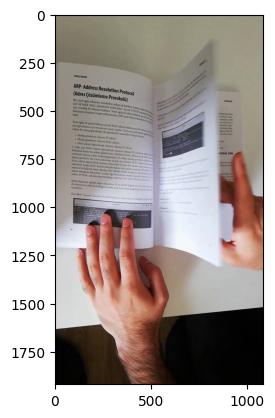

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = os.path.join(train_flip_dir, '0008_000000018.jpg')
image = mpimg.imread(image_path)
plt.imshow(image)

In [7]:
image.shape

(1920, 1080, 3)

Here we can see that the dimensions of the image are 1920 X 1080 X 3 which can easily be reduced to compress the image without losing information and this will be handled in our *ImageDataGenerator* . ( The 3 is for number of channels which is 3 showing a colored image )

### Data Preprocessing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 200 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200X200
        batch_size=200,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 50 using valid_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200X200
        batch_size=50,
        class_mode='binary')

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


### Step2 : Creating a CNN model and training the network with appropriate loss function for training and validation

#### a. Creating the model with convolution, maxpooling and batch norm

In [9]:
def create_model():

  # Define the model
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

#### b. Saving the model

In [10]:
# Save your model
model = create_model()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      self.model.stop_training = True

#### Now using F1-Score for performance evaluation rather than accuracy

In [11]:
from keras import backend as K

# Define a custom F1 score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())

    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

In [12]:
# !pip install tensorflow-addons
!pip install tfa-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 9.7 MB/s eta 0:00:00


In [13]:
tf.version.VERSION

'2.12.0'

In [14]:
!python --version


Python 3.10.12


In [15]:
model = create_model()

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy', f1_score])

In [16]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
12/12 [==============================] - 541s 46s/step - loss: 1.9248 - accuracy: 0.5376 - f1_score: 0.4053 - val_loss: 0.6571 - val_accuracy: 0.6013 - val_f1_score: 0.7150
Epoch 2/20
12/12 [==============================] - 45s 4s/step - loss: 0.6117 - accuracy: 0.6492 - f1_score: 0.6480 - val_loss: 0.5502 - val_accuracy: 0.7471 - val_f1_score: 0.7907
Epoch 3/20
12/12 [==============================] - 45s 4s/step - loss: 0.4649 - accuracy: 0.7952 - f1_score: 0.8201 - val_loss: 0.4055 - val_accuracy: 0.8576 - val_f1_score: 0.8448
Epoch 4/20
12/12 [==============================] - 45s 4s/step - loss: 0.2748 - accuracy: 0.9055 - f1_score: 0.9065 - val_loss: 0.2837 - val_accuracy: 0.8744 - val_f1_score: 0.8877
Epoch 5/20
12/12 [==============================] - 44s 4s/step - loss: 0.1536 - accuracy: 0.9461 - f1_score: 0.9482 - val_loss: 0.1648 - val_accuracy: 0.9414 - val_f1_score: 0.9420
Epoch 6/20
12/12 [==============================] - 45s 4s/step - loss: 0.0838 - accurac

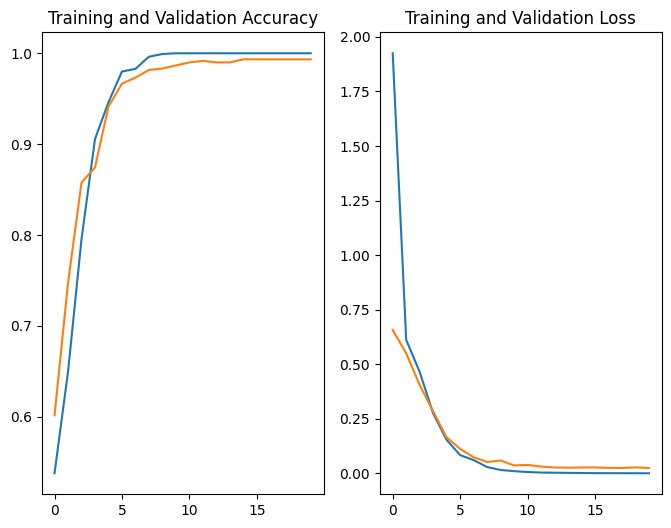

In [17]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()


## RESULT:

There is not a lot of imbalance in the dataset minimum pre-processing was needed for a good result. A CNN was built for this binary classification problem with 2 convolution layers and 2 max pooling layers. The metric for performance evaluation , F1 Score can be seen from above to have reached a stable value till the 10th epoch itself, so we can apply early stopping to stop it early according to our expected score value. The accuracy also is pretty high, almost 100% which can signal overfitting which can be tackled with adding dropout layer to the above network configuration.



#### Let us also try to make a prediction for a value to see how our algorithm works.

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import cv2
from PIL import Image

def predict_flip (image_path):
  image = Image.open(image_path)
  resized_image = image.resize([200,200])
  resized_image = np.expand_dims(resized_image, axis=0)
  norm_image = (resized_image/255.0)
  y_pred = (model.predict(resized_image))
  print(y_pred)
  if y_pred == 0:
      print('This is not an image of page flipping')
  else:
    print('This is an image of a page being flipped')


In [ ]:
predict_flip()

In [61]:
# Taking a page flipped image from train dataset

image_path = os.path.join(train_flip_dir, '0008_000000018.jpg')
predict_flip(image_path)

1/1 [==============================] - 0s 28ms/step
[[1.]]
This is an image of a page being flipped


In [74]:
# Taking a page flipped image from train dataset

image_path = os.path.join(train_notflip_dir, '0002_000000007.jpg')
predict_flip(image_path)

1/1 [==============================] - 0s 28ms/step
[[1.]]
This is an image of a page being flipped


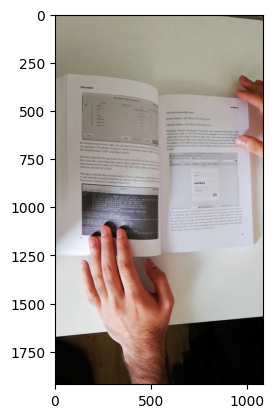

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = os.path.join(train_notflip_dir, '0002_000000007.jpg')
image = mpimg.imread(image_path)
plt.imshow(image)